# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam Project
### Letizia Mancini, letizia.mancini3@studio.unibo.it

## Step B - Multiple Instance Detection:

### General Hough Transform with Local Invariant Features (Star Model)

#### Off-line phase
1. **Detect Keypoints** in the model images
2. **Compute Descriptors**
    - choose a reference point **Pc** (e.g. barycenter of all the keypoints )
    - compute the joining vector **Vi** between the feature (each keypoint **Ki** with position **Pi**) and the reference point: **Vi = Pc - Pi**
    
#### On-line phase
3. **Detect Keypoints and Compute Descriptors** in the target image
4. **Match Descriptors between Target and Model Features**
5. **Cast Votes** for the position of the barycenter
6. **Position Estimation**

### Environment setup 

In [1]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

# image directories
scenes_dir = 'scenes'
models_dir = 'models'
# image names
scenes_name = ['m1.png', 'm2.png', 'm3.png', 'm4.png', 'm5.png']
models_name = ['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '25.jpg', '26.jpg']
# lists
scenes = []
models = []

for i in range( len(scenes_name) ):
    scenes.append(scenes_dir + "/" + scenes_name[i])
print(scenes)

for i in range( len(models_name) ):
    models.append(models_dir + "/" + models_name[i])
print(models)



['scenes/m1.png', 'scenes/m2.png', 'scenes/m3.png', 'scenes/m4.png', 'scenes/m5.png']
['models/0.jpg', 'models/1.jpg', 'models/11.jpg', 'models/19.jpg', 'models/24.jpg', 'models/25.jpg', 'models/26.jpg']


#### Loading the images

In [2]:
img_train = []
img_query = [] 

# load the query images
for i in range(len(models)):
    img_query.append( cv2.imread(models[i], cv2.IMREAD_GRAYSCALE) ) # queryImage


### Offline phase
Local invariant feature together with the GHT

#### 1. Keypoint Detection
Initialize the SIFT detector object in the following way:

In [3]:
# Creating SIFT object 
sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers=5, contrastThreshold=0.1, sigma=1.4)

Then we need to find keypoints. We will use detect method of the SIFT detector object. Let us find the keypoints of the query image:

In [4]:
# find the keypoints and descriptors with SIFT
kp_query = []

for img in img_query:
    kp_query.append(sift.detect(img))
    # Number of keypoints
    print(len(kp_query))

1
2
3
4
5
6
7


#### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support).
We will use the SIFT descriptor for this sample study. We can use the same SIFT detector object calling the *compute* method:

In [5]:
## utils
def barycenter(keypoints):
    x = 0
    y = 0
    
    for kp in keypoints:
        x += kp.pt[0]
        y += kp.pt[1]
        
    x = x/len(keypoints)
    y = y/len(keypoints)
    
    return (x, y)    

In [6]:
#The extended keypoint class contains the coordinates of the point, angle, size, descriptor and the voting parameter
class ExtendedKeyPoint:
    def __init__(self, kp, pc, desc):
        self.kp = kp #kp contains in itself point, angle, size
        self.desc = desc
        #difference between barycenter and the point returns the Vi vector
        self.vi = (pc[0] - kp.pt[0], pc[1] - kp.pt[1])
        

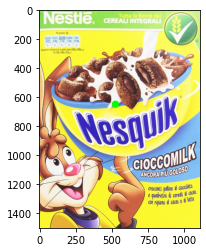

barycenter in (524.22, 648.84)


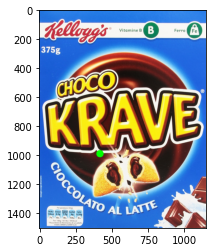

barycenter in (418.75, 988.60)


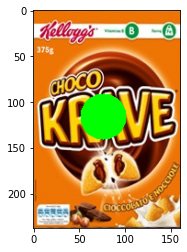

barycenter in (76.51, 116.59)


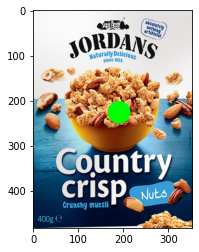

barycenter in (190.41, 226.10)


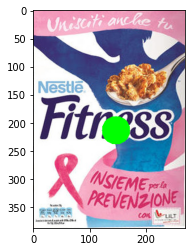

barycenter in (147.28, 213.71)


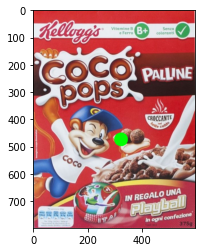

barycenter in (321.79, 473.87)


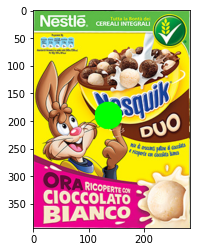

barycenter in (136.98, 190.55)


In [7]:
# Describing keypoints for query images 
## array perché lista mi dava errori sugli indici
des_query = np.empty(len(img_query), dtype=object)
kp_query_extended = []
img_query_rgb = [] ## immagini a colori

for img in models:
    img_query_rgb.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))


for i in range(len(img_query)):
    kp_query[i], des_query[i] = sift.compute(img_query[i], kp_query[i])
    #pc = calculate_barycentre_from_shape(img_query[i].shape)
    pc = barycenter(kp_query[i])
    kp_query_extended.append([])
    for k in range(len(kp_query[i])):
        kp_query_extended[i].append(ExtendedKeyPoint(kp_query[i][k], pc, des_query[i][k]))
    ##print rgb image with barycentre
    center_coordinates = (np.int32(pc[0]), np.int32(pc[1]))
    img_query_rgb[i] = cv2.circle(img_query_rgb[i], center_coordinates, radius=25, color=(0, 255, 0), thickness=-1)
    plt.imshow(img_query_rgb[i])
    plt.show()
    print(f'barycenter in ({pc[0]:.2f}, { pc[1]:.2f})')
    


### Online phase

Load the target images

In [8]:
# load the train images (da fare ONLINE)
for i in range( len(scenes) ):
    img_train.append( cv2.imread(scenes[i], cv2.IMREAD_GRAYSCALE) ) # trainImage

#### 3. Scene Keypoint Detection
Initialize the SIFT detector object in the following way:

In [9]:
# find the keypoints and descriptors with SIFT
kp_train = []

for img in img_train:
    kp_train.append(sift.detect(img))
    # Number of keypoints
    print(len(kp_train))

1
2
3
4
5


In [11]:
# Describing keypoints for query and train images 
## array perché lista mi dava errori sugli indici
des_train = np.empty(len(img_train), dtype=object)

for i in range(len(img_train)):
    kp_train[i], des_train[i] = sift.compute(img_train[i], kp_train[i])
    print(des_train[i])

[[ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  1.]
 ...
 [ 0.  2.  1. ... 10.  0.  0.]
 [ 0.  0.  0. ...  1. 34. 31.]
 [ 1.  4. 25. ...  0.  0.  0.]]
[[  0.   0.   1. ...  18.   1.   2.]
 [  0.   0.   3. ...  31.   0.   1.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  2.   1.   1. ...   0.   0.   0.]
 [  0.   0.   2. ...   0.   0.   0.]
 [ 54. 105.   1. ...   0.   0.   0.]]
[[  0.   0.   0. ...   7.   0.   0.]
 [ 37.  20.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...  10.   0.   6.]
 ...
 [126.   2.   0. ...   1.  11.   7.]
 [  0.   0.   0. ...   0.  12. 136.]
 [ 42.  18.   0. ...   0.   1.   6.]]
[[  0. 144. 150. ...   0.   0.   0.]
 [ 13.   4.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   4.   0.   1.]
 ...
 [  2.  21.  26. ...  10.   2.   6.]
 [ 64.  27.   0. ...  34.   7.   5.]
 [  1.   0.   0. ...   1.   0.   1.]]
[[ 10.   1.   0. ...   0.   0.   0.]
 [  3.   0.   0. ...   1.   0.   0.]
 [  0.   0.  15. ...   2.   0.   2.]
 ...
 [  0.  

#### 4. Match with Query Images
Match descriptors between target and model features

In [12]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time 
search_params = dict(checks = 300)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
# in each scene i search the match for each cereal box
image_matches = np.empty(len(img_train), dtype=object)
i = 0 #index for the train images

for des_t in des_train: #for each scene
    image_matches[i] = [] #create a list that will hold the matches wrt each model image
    for des_q in des_query: #for each query image
        image_matches[i].append(flann.knnMatch(des_q,des_t,k=2)) #compute at most 2 matches per keypoint matches
    i = i+1

In [13]:
good = np.empty(len(image_matches), dtype=object)
i = 0

for match_list in image_matches:
    good[i] = np.empty(len(img_query), dtype=object)
    j = 0
    for matches in match_list:
        good[i][j] = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good[i][j].append(m)
        j += 1
    i += 1

#### 5. GHT - cast votes for barycenter
The Hough Space points are defined by:
- position `pt`: the barycenter
- scale `s`: the ratio of size between the matching features (the matched keypoint size and the source keypoint size)
- angle `phi`: the difference between the matched keypoint angle and the source keypoint angle

After computing them, we quantize them in intervals of position through a dictionary:
- the keys are the positions divided by the `QUANTIZATION` parameter and rounded
- the value is the list of barycenters that fall into that interval

Thanks to the closeness measurement, we can clusterize the barycenters

In [14]:
class HoughSpacePoint:
    def __init__(self, query_ext_kp, matched_kp):
        self.src_kp = query_ext_kp.kp
        self.dest_kp = matched_kp
        self.s = matched_kp.size/query_ext_kp.kp.size
        self.phi = matched_kp.angle - query_ext_kp.kp.angle
        #the angle is not used in the function below because it gives worse results
#        self.R = np.array([[np.cos(self.phi), - np.sin(self.phi)],
#                           [np.sin(self.phi), np.cos(self.phi)]])
#        self.rot_vi = np.matmul(self.R, np.array([query_ext_kp.vi[0],query_ext_kp.vi[1]]))
#       self.pt = (matched_kp.pt[0]+self.s*self.rot_vi[0], matched_kp.pt[1]+self.s*self.rot_vi[1])
        self.pt = (matched_kp.pt[0]+self.s*query_ext_kp.vi[0], matched_kp.pt[1]+self.s*query_ext_kp.vi[1])

In [15]:
barycenters_votes = np.empty(len(img_train), dtype=object)
i=0
QUANTIZATION=100
for mat_img in image_matches:#for each list of matches related to an image wrt a train image
    j = 0
    barycenters_votes[i] = np.empty(len(img_query), dtype=dict)
    for matches in mat_img: # for each list of matches related to the query image j
        barycenters_votes[i][j] = dict()
        img_shape = np.shape(img_train[i])
        for m in good[i][j]:
            bary_vote = HoughSpacePoint(kp_query_extended[j][m.queryIdx],kp_train[i][m.trainIdx]) 
            
            ## check img_shape
            if bary_vote.pt[0] >= 0 and bary_vote.pt[1] >= 0 and bary_vote.pt[0] <= img_shape[1] and bary_vote.pt[1] <= img_shape[0]:
                q_pt = (int(math.floor(bary_vote.pt[0]/QUANTIZATION)), int(math.floor(bary_vote.pt[1]/QUANTIZATION)))
                
                if q_pt not in barycenters_votes[i][j]:            
                    barycenters_votes[i][j][q_pt] = list()
                barycenters_votes[i][j][q_pt].append(bary_vote)
        j+=1
    i+=1

Selecting the intervals with at least `TH` barycenters:

In [16]:
def get_max_length_list(dict_list, th):
    max_length = th
    max_k = []
    
    for k in dict_list:
        l = len(dict_list[k])
        if l > th:
            max_k.append(k)  
    return max_k

[GHT] looking for barycentres with at least 15 vote(s)...

[scenes/m1.png]

[models/0.jpg] 1 barycentre area hypothesis:
	 (9, 1) with 47 barycenters:
[models/1.jpg] 0 barycentre area hypothesis:
[models/11.jpg] 0 barycentre area hypothesis:
[models/19.jpg] 0 barycentre area hypothesis:
[models/24.jpg] 3 barycentre area hypothesis:
	 (2, 2) with 34 barycenters:
	 (5, 2) with 38 barycenters:
	 (1, 2) with 20 barycenters:
[models/25.jpg] 2 barycentre area hypothesis:
	 (12, 2) with 157 barycenters:
	 (12, 3) with 16 barycenters:
[models/26.jpg] 1 barycentre area hypothesis:
	 (9, 2) with 192 barycenters:


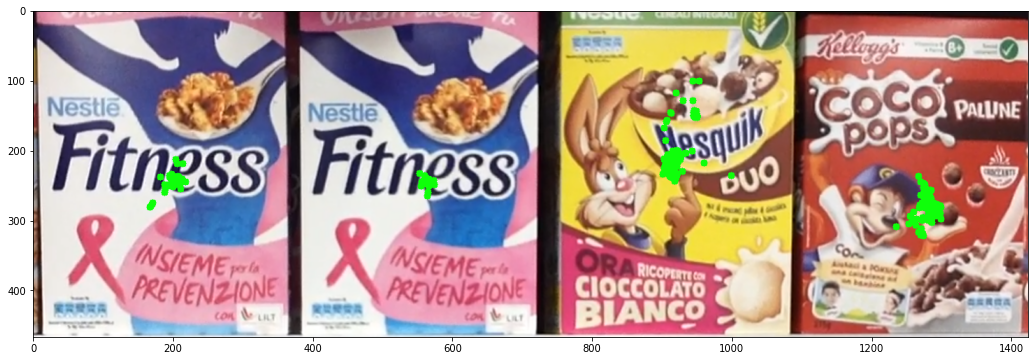

[scenes/m2.png]

[models/0.jpg] 1 barycentre area hypothesis:
	 (1, 2) with 221 barycenters:
[models/1.jpg] 3 barycentre area hypothesis:
	 (8, 3) with 47 barycenters:
	 (11, 3) with 29 barycenters:
	 (4, 3) with 21 barycenters:
[models/11.jpg] 2 barycentre area hypothesis:
	 (8, 2) with 21 barycenters:
	 (5, 2) with 22 barycenters:
[models/19.jpg] 0 barycentre area hypothesis:
[models/24.jpg] 0 barycentre area hypothesis:
[models/25.jpg] 0 barycentre area hypothesis:
[models/26.jpg] 1 barycentre area hypothesis:
	 (1, 3) with 67 barycenters:


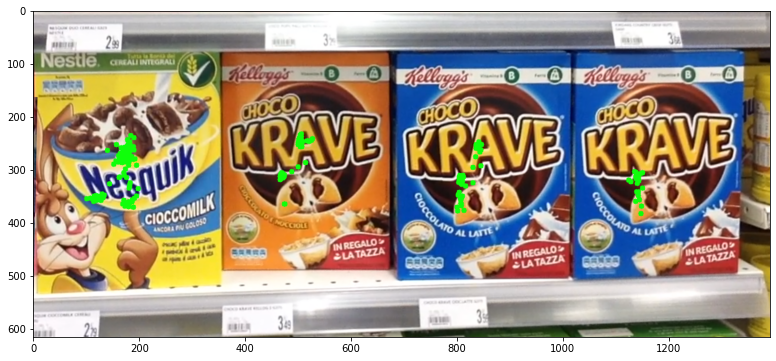

[scenes/m3.png]

[models/0.jpg] 2 barycentre area hypothesis:
	 (1, 1) with 24 barycenters:
	 (2, 1) with 45 barycenters:
[models/1.jpg] 0 barycentre area hypothesis:
[models/11.jpg] 0 barycentre area hypothesis:
[models/19.jpg] 1 barycentre area hypothesis:
	 (12, 1) with 144 barycenters:
[models/24.jpg] 0 barycentre area hypothesis:
[models/25.jpg] 2 barycentre area hypothesis:
	 (9, 2) with 52 barycenters:
	 (5, 2) with 63 barycenters:
[models/26.jpg] 2 barycentre area hypothesis:
	 (1, 2) with 180 barycenters:
	 (1, 1) with 60 barycenters:


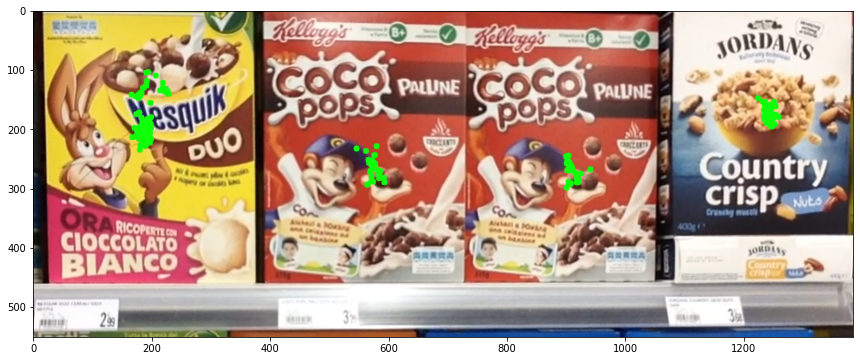

[scenes/m4.png]

[models/0.jpg] 1 barycentre area hypothesis:
	 (9, 1) with 40 barycenters:
[models/1.jpg] 0 barycentre area hypothesis:
[models/11.jpg] 0 barycentre area hypothesis:
[models/19.jpg] 0 barycentre area hypothesis:
[models/24.jpg] 2 barycentre area hypothesis:
	 (5, 2) with 39 barycenters:
	 (1, 2) with 32 barycenters:
[models/25.jpg] 2 barycentre area hypothesis:
	 (12, 2) with 58 barycenters:
	 (16, 2) with 41 barycenters:
[models/26.jpg] 2 barycentre area hypothesis:
	 (9, 1) with 115 barycenters:
	 (9, 2) with 36 barycenters:


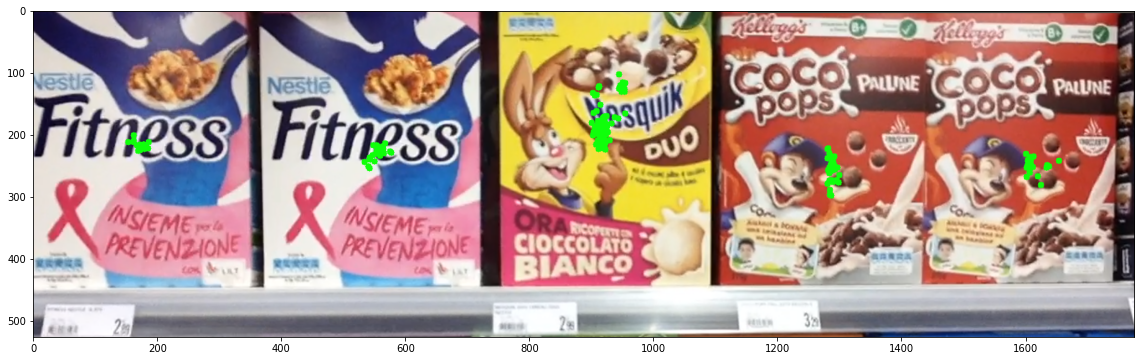

[scenes/m5.png]

[models/0.jpg] 0 barycentre area hypothesis:
[models/1.jpg] 3 barycentre area hypothesis:
	 (4, 7) with 26 barycenters:
	 (1, 7) with 18 barycenters:
	 (7, 7) with 18 barycenters:
[models/11.jpg] 2 barycentre area hypothesis:
	 (1, 7) with 30 barycenters:
	 (4, 7) with 19 barycenters:
[models/19.jpg] 1 barycentre area hypothesis:
	 (9, 1) with 113 barycenters:
[models/24.jpg] 0 barycentre area hypothesis:
[models/25.jpg] 2 barycentre area hypothesis:
	 (2, 2) with 46 barycenters:
	 (5, 2) with 38 barycenters:
[models/26.jpg] 0 barycentre area hypothesis:


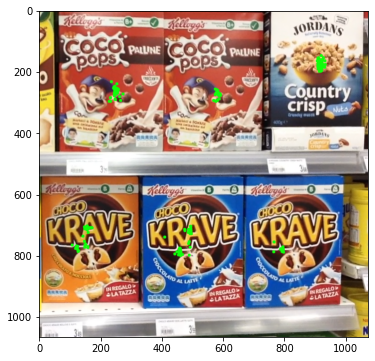

In [17]:
img_train_rgb = []
for p in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

THRESHOLD = 15
max_bary_keys = []

print(f"[GHT] looking for barycentres with at least {THRESHOLD} vote(s)...\n")
for i in range(len(img_train)):
    color = (15, 255, 10)
    max_bary_keys.append([])
    print(f"[{scenes[i]}]\n")
    for j in range(len(img_query)):
        max_bary_keys[i].append([])
        max_bary_keys[i][j] = get_max_length_list(barycenters_votes[i][j], THRESHOLD)
        print("[{}] {} barycentre area hypothesis:".format(models[j], len(max_bary_keys[i][j])))
    #print("\n")

# print barycenters on images
        for pt in max_bary_keys[i][j]:
            print(f"\t {pt} with {len(barycenters_votes[i][j][pt])} barycenters:")
            for bary_vote in barycenters_votes[i][j][pt]:
                coordinates = (np.int32(bary_vote.pt[0]), np.int32(bary_vote.pt[1]))
                img_train_rgb[i] = cv2.circle(img_train_rgb[i], coordinates,radius=5, color=color, thickness=-1)

    plt.figure(figsize = (40,6))
    plt.imshow(img_train_rgb[i])
    plt.show()
############################



#### 6. Position Estimation

We can use **RANSAC** to estimate an homography from good matches and discard the wrong ones

In [18]:
def threshold(pt1, pt2, th):
    dist = np.linalg.norm(pt1 - pt2)
    return dist <= th

In [19]:
## utils
class BoundingBox:
    def __init__(self, dst, scene_height, scene_width):
        self.dst = dst
        self.update(scene_height, scene_width) ## definire
        self.centre = dst.mean(axis=0)[0]
        
        self.corners = [(pt[0][0], pt[0][1]) for pt in dst]
        self.h = (self.corners[2][1] + self.corners[1][1] - self.corners[0][1] - self.corners[3][1])/2
        self.w = (self.corners[2][0] + self.corners[3][0] - self.corners[0][0] - self.corners[1][0])/2
        
            
    def update(self, scene_height, scene_width):
        i = 0
        for pt in self.dst:
            x = pt[0][0]
            y = pt[0][1]
            
            if x < 0.0:
                x = 0.0
            elif x > scene_width:
                x = scene_width
            
            if y < 0.0:
                y = 0.0
            elif y > scene_height:
                y = scene_height
            self.dst[i][0] = (x, y)
            i += 1

In [20]:
def check_overlapping(boxes, j, pt, th):
    if j == 0 and len(boxes[j]) == 0:
        return -1, pt
   # print('examining potential overlaps for center = {}'.format(centers[j][pt]))

    for img in range(j+1): #includes also current image
        if boxes[img] is not None:
            for tmp_pt in boxes[img]:
                if boxes[img][tmp_pt] is not None:
    #                print('\tconfronting with image {} with center = {} in area {}'.format(models[img],centers[img][tmp_pt], tmp_pt))
                    if threshold(boxes[j][pt].centre, boxes[img][tmp_pt].centre, th):
     #                   print('OVERLAPS')
                        return img, tmp_pt
    return -1, pt

scene 0

Product 0 - 0 instances found.
Product 1 - 0 instances found.
Product 2 - 0 instances found.
Product 3 - 0 instances found.
Product 4 - 2 instances found.
	Instance 1 in (185.56, 232.20), width: 352px, height: 464px 
	Instance 2 in (550.68, 233.36), width: 336px, height: 467px 
Product 5 - 1 instances found.
	Instance 1 in (1261.79, 233.32), width: 313px, height: 443px 
Product 6 - 1 instances found.
	Instance 1 in (921.35, 230.92), width: 333px, height: 462px 


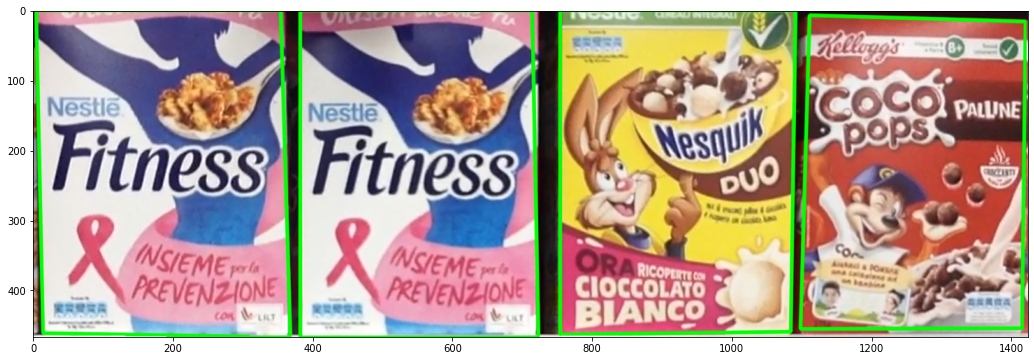



scene 1

Product 0 - 1 instances found.
	Instance 1 in (179.65, 301.19), width: 344px, height: 450px 
Product 1 - 2 instances found.
	Instance 1 in (848.13, 259.32), width: 312px, height: 410px 
	Instance 2 in (1178.23, 243.91), width: 302px, height: 402px 
Product 2 - 1 instances found.
	Instance 1 in (511.42, 252.70), width: 307px, height: 403px 
Product 3 - 0 instances found.
Product 4 - 0 instances found.
Product 5 - 0 instances found.
Product 6 - 0 instances found.


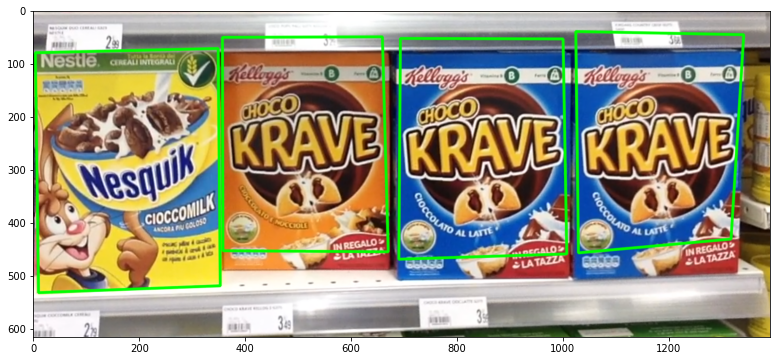



scene 2

Product 0 - 0 instances found.
Product 1 - 0 instances found.
Product 2 - 0 instances found.
Product 3 - 1 instances found.
	Instance 1 in (1232.93, 190.75), width: 296px, height: 381px 
Product 4 - 0 instances found.
Product 5 - 2 instances found.
	Instance 1 in (889.95, 222.69), width: 319px, height: 436px 
	Instance 2 in (558.35, 274.40), width: 366px, height: 548px 
Product 6 - 1 instances found.
	Instance 1 in (195.22, 229.65), width: 354px, height: 459px 


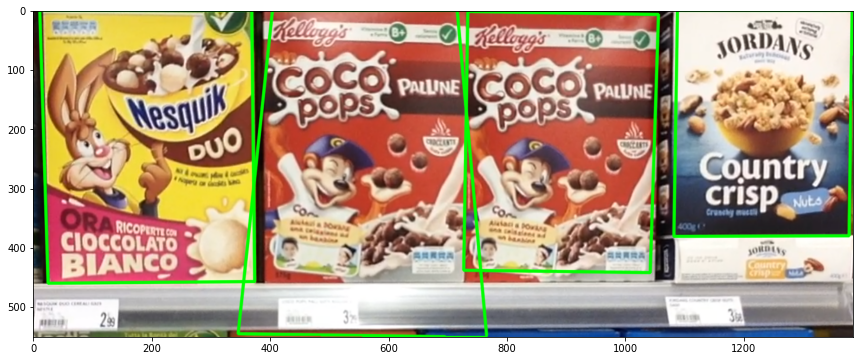



scene 3

Product 0 - 0 instances found.
Product 1 - 0 instances found.
Product 2 - 0 instances found.
Product 3 - 0 instances found.
Product 4 - 2 instances found.
	Instance 1 in (540.69, 223.21), width: 348px, height: 446px 
	Instance 2 in (172.93, 225.46), width: 346px, height: 451px 
Product 5 - 2 instances found.
	Instance 1 in (1264.90, 263.00), width: 365px, height: 526px 
	Instance 2 in (1590.08, 212.34), width: 305px, height: 425px 
Product 6 - 1 instances found.
	Instance 1 in (921.80, 221.14), width: 341px, height: 442px 


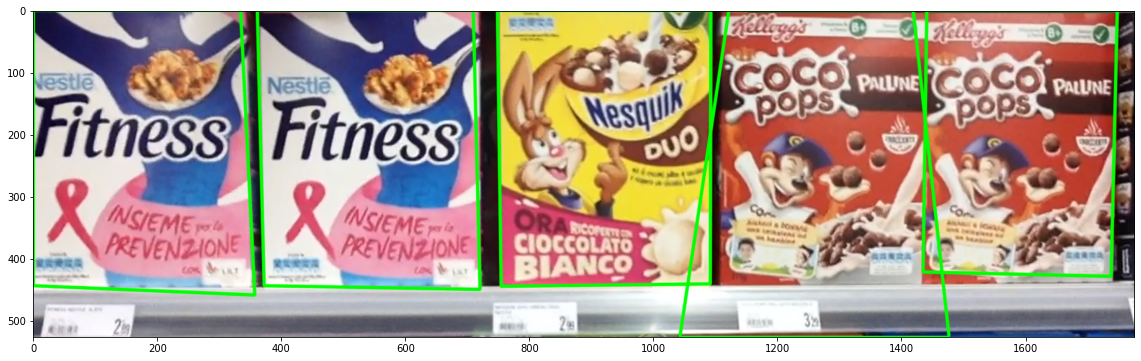



scene 4

Product 0 - 0 instances found.
Product 1 - 2 instances found.
	Instance 1 in (501.01, 720.70), width: 313px, height: 412px 
	Instance 2 in (832.10, 715.91), width: 301px, height: 411px 
Product 2 - 1 instances found.
	Instance 1 in (163.62, 716.13), width: 308px, height: 407px 
Product 3 - 1 instances found.
	Instance 1 in (909.05, 191.40), width: 296px, height: 382px 
Product 4 - 0 instances found.
Product 5 - 2 instances found.
	Instance 1 in (235.17, 223.99), width: 335px, height: 448px 
	Instance 2 in (563.97, 290.73), width: 358px, height: 564px 
Product 6 - 0 instances found.


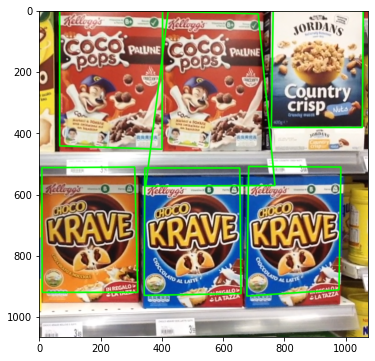

In [21]:
# Checking if we found enough matching
img_train_rgb = []
for p in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

matchesMask = np.empty(len(img_train), dtype=object)
boxes = np.empty(len(img_train), dtype=object)
color = (0, 255, 0)
TH=150

for i in range(len(img_train)):
    print(f"scene {i}\n")
    tmp_kp_train = kp_train[i]
    matchesMask[i] = np.empty(len(img_query), dtype=object)
    boxes[i] = np.empty(len(img_query), dtype=dict)
    
    for j in range(len(img_query)):
        boxes[i][j] = dict()
        for pt in max_bary_keys[i][j]:
            tmp_kp_query = barycenters_votes[i][j][pt]
            # building the correspondences arrays of good matches
            src_pts = np.float32([ bary.src_kp.pt for bary in barycenters_votes[i][j][pt] ]).reshape(-1,1,2)
            dst_pts = np.float32([ bary.dest_kp.pt for bary in barycenters_votes[i][j][pt] ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Corners of the query image
            h,w = img_query[j].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            
            # Projecting the corners into the train image
            boxes[i][j][pt] = BoundingBox(cv2.perspectiveTransform(pts,M), img_train[i].shape[0], img_train[i].shape[1])
            #check if in the same scene there are overlapping boxes from different imgs
        
            overlap_idx, overlap_pt = check_overlapping(boxes[i], j, pt, TH)
            if overlap_idx > -1 and ((overlap_idx != j) or (overlap_idx == j and overlap_pt != pt)):
                if len(barycenters_votes[i][j][pt]) >= len(barycenters_votes[i][overlap_idx][overlap_pt]):
                    del boxes[i][overlap_idx][overlap_pt]
                else:
                    del boxes[i][j][pt]                    
            
    for j in range(len(img_query)):
        if boxes[i][j] is not None:
            print(f'Product {j} - {len(boxes[i][j])} instances found.')
            k=1
            for pt in boxes[i][j]:
                if boxes[i][j][pt] is not None:
                    current = boxes[i][j][pt]
                    print(f'\tInstance {k} in ({current.centre[0]:.2f}, { current.centre[1]:.2f}), width: {current.w:.0f}px, height: {current.h:.0f}px ')
                    # Drawing the bounding box
                    k+=1
                    img_train_rgb[i] = cv2.polylines(img_train_rgb[i],[np.int32(boxes[i][j][pt].dst)],True,color,3, cv2.LINE_AA)
    plt.figure(figsize = (40,6))
    plt.imshow(img_train_rgb[i])
    plt.show() 
    print("\n")
